# AutoEncoder

The following autoencoder is based on the following websites:

 - https://medium.datadriveninvestor.com/covid-19-detection-in-x-ray-images-with-pytorch-5c5602b4658f
 - https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1
 - https://gist.github.com/AFAgarap/4f8a8d8edf352271fa06d85ba0361f26#file-autoencoder-pytorch-ipynb
 - https://discuss.pytorch.org/t/how-to-load-images-without-using-imagefolder/59999/2

### Import Fiesta

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
from collections import OrderedDict
from pathlib import Path
import uuid
#import pydicom
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Import essential libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
#from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time
import random
%matplotlib inline
import torch.nn as nn
import torch.optim as optim
import gzip

## File I/O

In [2]:
cxr_root_path = "/media/Data/ComputerVision/mimic_cxr_jpg_small_chest_radiograph/data/physionet.org/files/mimic-cxr-jpg/2.0.0/"
record_df = pd.read_csv('{}/cxr-record-list.csv.gz'.format(cxr_root_path), sep=',')
record_df.head()

,subject_id,study_id,dicom_id,path
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...


In [3]:
print('Total number of unique patients: {}'.format(len(record_df['subject_id'].unique())))
print('Total number of unique studies: {}'.format(len(record_df['study_id'].unique())))
print('On average each patient has {:.3f} studies'.format(len(record_df['study_id'].unique())/len(record_df['subject_id'].unique())))

Total number of unique patients: 65379
Total number of unique studies: 227835
On average each patient has 3.485 studies


## Visualizing an Image

reading the following: 
files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm
files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg


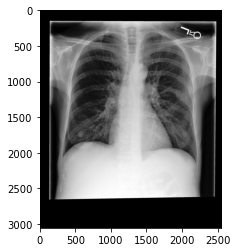

In [4]:
file_path = record_df.iloc[0]['path']
print('reading the following: \n{}'.format(file_path))
# load in JPG(actual image format in server)
file_path = file_path[:-4]+'.jpg'
print(file_path)
img = Image.open('{}/{}'.format(cxr_root_path, file_path)).convert('RGB')
plt.imshow(img)
plt.show()

## Data Stats

In [5]:
df_split = pd.read_csv('{}/mimic-cxr-2.0.0-split.csv.gz'.format(cxr_root_path))
#decided not to read metadata file, was causing permission errors
dataset = df_split.merge(record_df, on=['subject_id', 'study_id', 'dicom_id'], how='left')
num_images=len(dataset)
print(num_images)
#dataset.loc[dataset['split']=="train"]
print(dataset['split'].unique())

377110
['train' 'validate' 'test']


In [6]:
print(len(dataset['split'].unique()))
dataset

3


,dicom_id,study_id,subject_id,split,path
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,50414267,10000032,train,files/p10/p10000032/s50414267/02aa804e-bde0afd...
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,50414267,10000032,train,files/p10/p10000032/s50414267/174413ec-4ec4c1f...
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,53189527,10000032,train,files/p10/p10000032/s53189527/2a2277a9-b0ded15...
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,53189527,10000032,train,files/p10/p10000032/s53189527/e084de3b-be89b11...
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,53911762,10000032,train,files/p10/p10000032/s53911762/68b5c4b1-227d048...
...,...,...,...,...,...
377105,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,57132437,19999733,train,files/p19/p19999733/s57132437/428e2c18-5721d8f...
377106,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,57132437,19999733,train,files/p19/p19999733/s57132437/58c403aa-35ff8bd...
377107,58766883-376a15ce-3b323a28-6af950a0-16b793bd,55368167,19999987,train,files/p19/p19999987/s55368167/58766883-376a15c...
377108,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,58621812,19999987,train,files/p19/p19999987/s58621812/7ba273af-3d290f8...


## AutoEncoder Implementation

https://stackoverflow.com/questions/61391919/loading-image-data-from-pandas-to-pytorch

In [7]:
import torch.optim as optim
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

cuda


In [8]:
class CustomDatasetFromImages(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms=None): 
        self.dataframe = dataframe
        self.transforms = transforms
    def __getitem__(self, index):
        imagepath=self.dataframe["path"].iloc[index]
        imagepath=cxr_root_path+imagepath[:-4]+'.jpg'
        image=Image.open(imagepath)
        if self.transforms is not None:
            image=self.transforms(image)
        return image
    def __len__(self):
        return len(self.dataframe)

In [9]:
train_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                            torchvision.transforms.RandomRotation((-20, 20)),
                                            torchvision.transforms.ToTensor()])
test_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),torchvision.transforms.ToTensor()])

In [10]:
train_set=CustomDatasetFromImages(dataset.loc[dataset['split']=='train'], transforms=train_Aug)
test_set=CustomDatasetFromImages(dataset.loc[dataset['split']=='validate'], transforms=test_Aug)
trainloader= torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=2,shuffle=True,**kwargs) 
testloader= torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=2, shuffle=False,**kwargs)

In [11]:
import torch.nn as nn
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed

In [12]:
epochs = 2
learning_rate = 1e-3

In [13]:

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=50176).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [14]:
for epoch in range(epochs):
    loss = 0
    i=0;
    for batch_features in trainloader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        if i%150==0:
            print(i)
        batch_features = batch_features.view(-1, 50176).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        i=i+1
    
    # compute the epoch training loss
    loss = loss / len(trainloader)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

0
150
300
450
600
750
900
1050
1200
1350
1500
1650
1800
1950
2100
2250
2400
2550
2700
2850
3000
3150
3300
3450
3600
3750
3900
4050
4200
4350
4500
4650
4800
4950
5100
5250
5400
5550
5700
epoch : 1/2, recon loss = 0.02004379
0
150
300
450
600
750
900
1050
1200
1350
1500
1650
1800
1950
2100
2250
2400
2550
2700
2850
3000
3150
3300
3450
3600
3750
3900
4050
4200
4350
4500
4650
4800
4950
5100
5250
5400
5550
5700
epoch : 2/2, recon loss = 0.01455171


In [15]:

with torch.no_grad():
    for batch_features in testloader:
        batch_features = batch_features[0:50].to(device)
        test_examples = batch_features.view(-1, 50176)
        reconstruction = model(test_examples)
        break

/media/SharedUsers/sdo19/home/anaconda3/envs/torch171/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


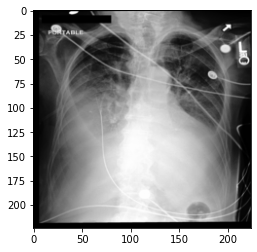

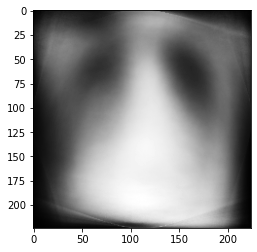

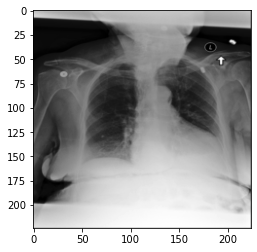

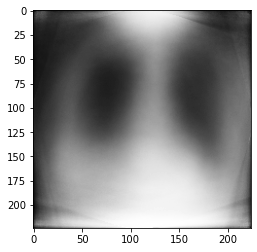

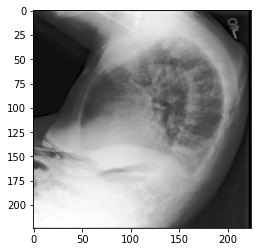

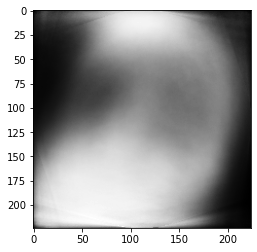

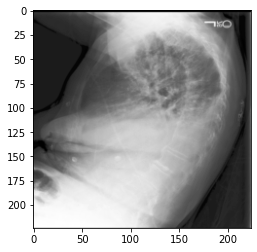

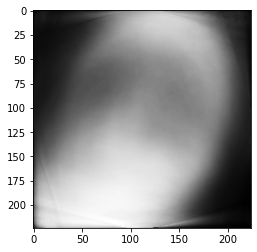

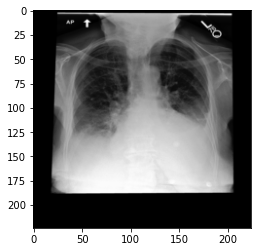

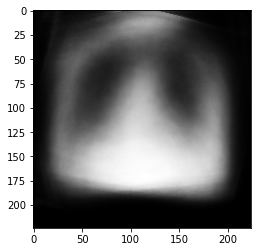

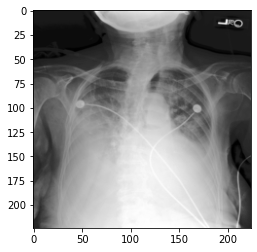

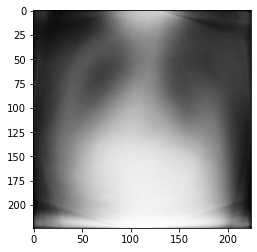

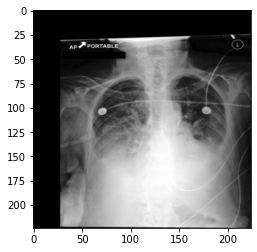

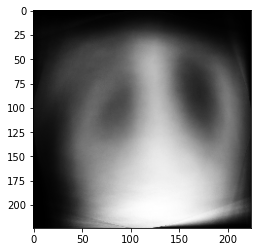

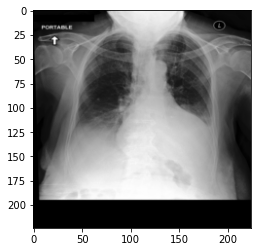

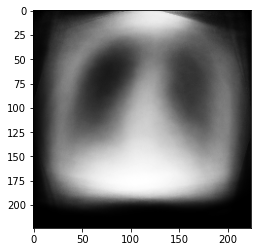

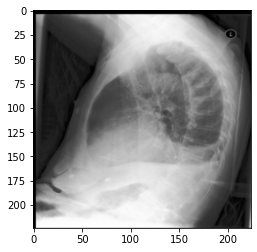

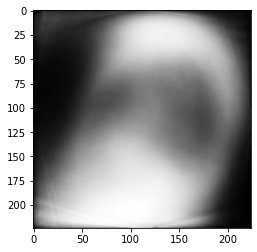

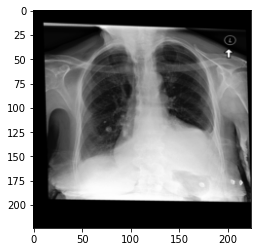

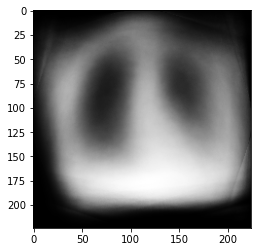

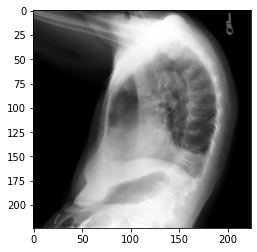

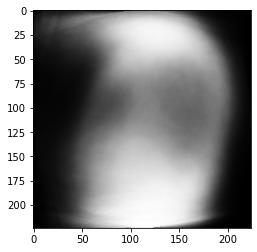

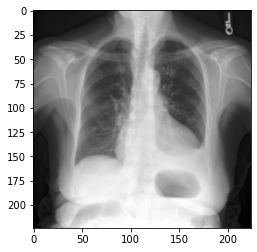

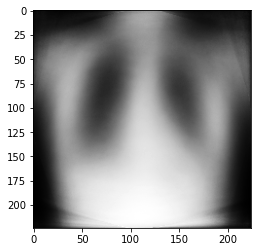

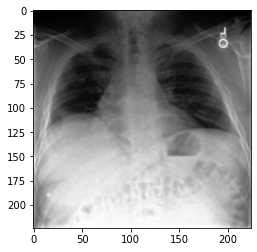

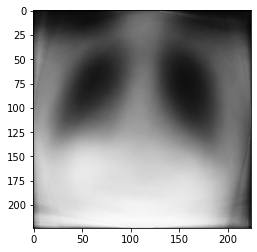

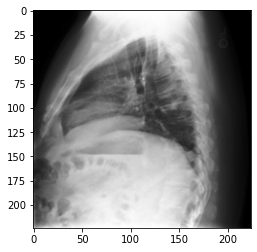

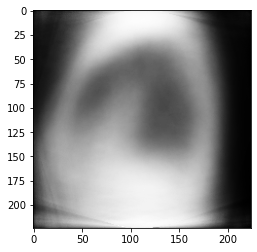

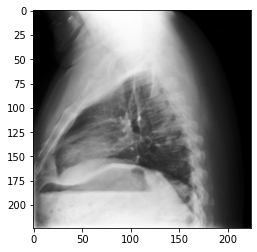

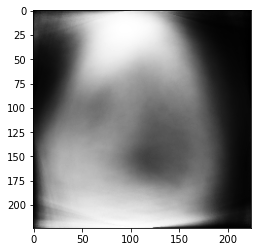

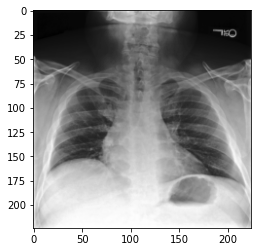

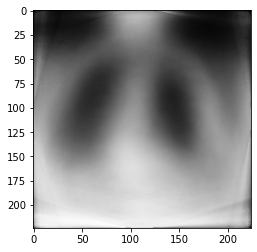

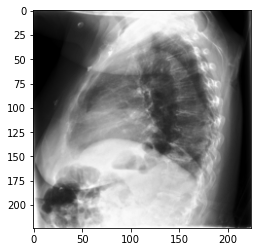

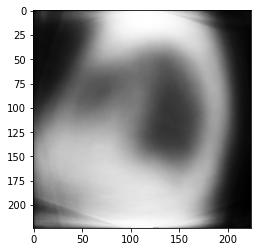

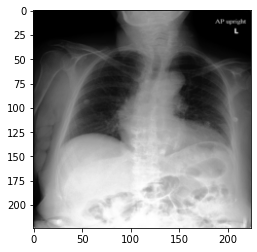

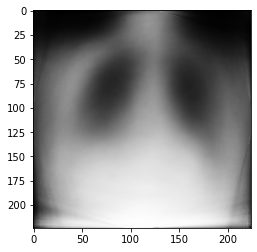

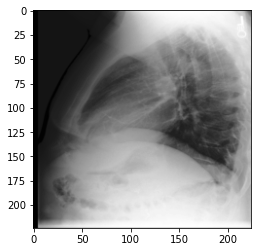

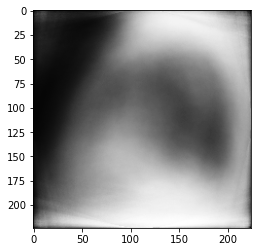

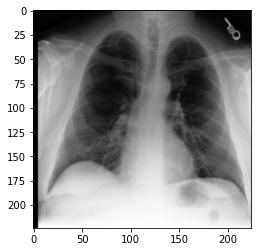

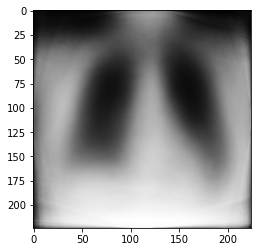

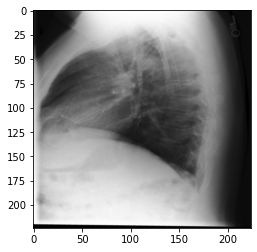

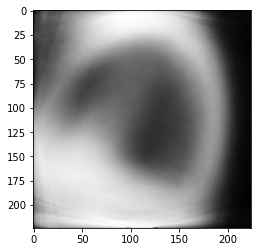

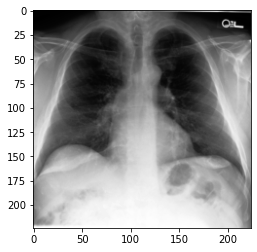

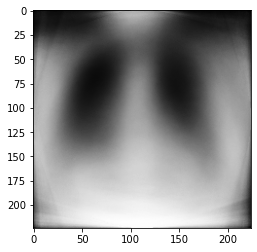

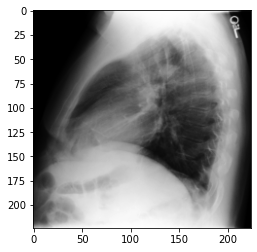

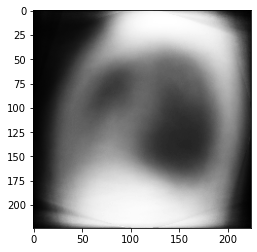

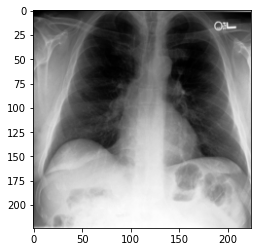

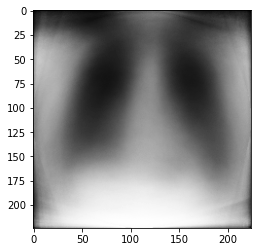

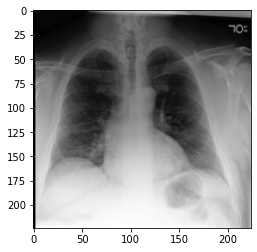

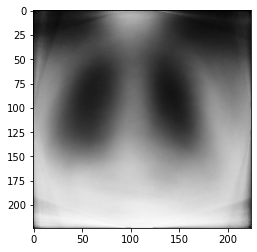

In [16]:
with torch.no_grad():
    number = 25
    #plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        #ax = plt.subplot(2, number, index + 1)
        plt.figure()
        plt.imshow(test_examples[index].cpu().numpy().reshape(224, 224))
        plt.gray()
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)

        # display reconstruction
        #ax = plt.subplot(2, number, index + 1 + number)
        plt.figure()
        plt.imshow(reconstruction[index].cpu().numpy().reshape(224, 224))
        plt.gray()
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)
    plt.show()

                    

In [20]:
torch.save(model.state_dict(), 'model_weights.pth')

In [21]:
plt.close()